# 深層学習モデルの構築

簡単のために、"5"という数字かどうかを判定するモデルの作り方を見ていきます。

コードを多めに用意したので、自分で弄ってみながら理解を深めてみてください。

![](https://deepage.net/img/convolutional_neural_network/conv.jpg)

- 出典: https://deepage.net/deep_learning/2016/11/07/convolutional_neural_network.html

- 深層学習ではまず、何を入力にし何を出力(予測)してほしいのかを決めて、それに合うニューラルネットモデルを作ります。
- 今回は画像を入力にして、入力が"5"という数字なら1、違えば0のような0~1の1つの値を出力すればいいので、そのようなモデルを組んでいきます。
- NNでは何種類かのレイヤーと呼ばれる処理を重ねることで、入力から特徴を抽出し目的の出力を予測していきます。
- 人間は、多数のパラメータを持ったニューラルネットを用意しさえすればよく、どんなパラメータが良いのかは後から機械が決めてくれます(誤差逆伝播法)。

# 入力データの準備

In [1]:
import numpy as np
from tensorflow import keras

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

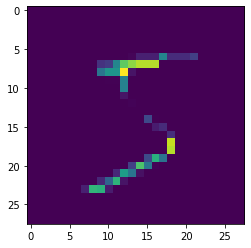

In [2]:
import cv2
import matplotlib.pyplot as plt

inp = x_train[0].squeeze()
inp = cv2.erode(inp, np.ones((3,3),np.uint8))
plt.imshow(inp); plt.show()

# Conv層 (畳み込み層)

視覚的な(空間方向の)特徴を抽出します。
- より具体的には、小さい重み画像とどのくらい似ているかを少しずつ場所をずらしながら調べます。
  - (どのような特徴が良いかは人間は決めず、あとから機械に決めてもらいます。)
- とりあえず実行してみましょう

<img src="https://deepage.net/img/convolutional_neural_network/animated_convolution.gif" width="640">

- 出典: https://deepage.net/deep_learning/2016/11/07/convolutional_neural_network.html

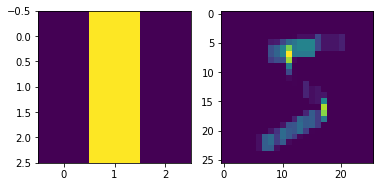

In [3]:
# weightはkernelとも呼びます
weight = np.array(
    [[0,1,0],
     [0,1,0],
     [0,1,0],])

plt.subplot(1,2,1); plt.imshow(weight)

H_out = inp.shape[0] - weight.shape[0] + 1
W_out = inp.shape[1] -weight.shape[1] + 1

out = np.zeros([H_out, W_out])

for i in range(H_out):
  for j in range(W_out):
    inp_ij = inp[i:i+weight.shape[0], j:j+weight.shape[1]]
    out[i,j] = np.dot(inp_ij.flatten(), weight.flatten())

plt.subplot(1,2,2); plt.imshow(out)
plt.show()

- 上では、縦線というわかりやすい重みを用意して畳み込み層を適用していて、実際に縦の成分が良く検出されたことが分かると思います。

In [4]:
# 関数化
def conv_simple(inp, weight):
  H_out = inp.shape[0] - weight.shape[0] + 1
  W_out = inp.shape[1] - weight.shape[1] + 1

  out = np.zeros([H_out, W_out])

  for i in range(H_out):
    for j in range(W_out):
      inp_ij = inp[i:i+weight.shape[0], j:j+weight.shape[1]]
      out[i,j] = np.dot(inp_ij.flatten(), weight.flatten())

  return out  # 特徴マップとも言います

- weightをいろいろ変えてみましょう。

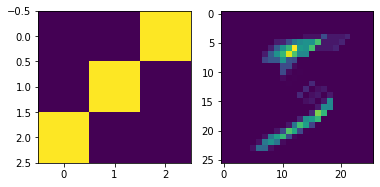

In [5]:
weight = np.array(
    [[0,0,1],
     [0,1,0],
     [1,0,0],])
# weight = np.random.rand(3,3)  # 0.~1.

plt.subplot(1,2,1); plt.imshow(weight)
out1 = conv_simple(inp, weight)
plt.subplot(1,2,2); plt.imshow(out1)
plt.show()

- 人間に分かる重み(特徴)だけを抽出していても限界があることが分かっており、実際にはランダムな重みを何百種類と与えて畳み込み層を適用します。
  - (そしてそのランダムな重みはあとから機械的に調整されます。)
- 今は入力画像に対して1枚の特徴マップしか出力されていませんが、実際には多数の重みを用意して多数の特徴マップを作ります(後述)。

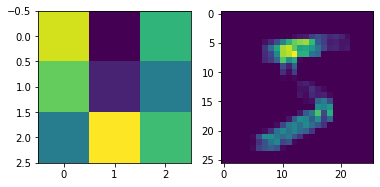

In [6]:
weight = np.random.rand(3,3)  # 0.~1.

plt.subplot(1,2,1); plt.imshow(weight)
out1 = conv_simple(inp, weight)
plt.subplot(1,2,2); plt.imshow(out1)
plt.show()

# Pool層

特徴マップの近くの値は似た値を持つので、代表値を採用して特徴マップを小さくします

<img src="https://deepage.net/img/convolutional_neural_network/max_pooling.jpg" width="640">

- 出典: https://deepage.net/deep_learning/2016/11/07/convolutional_neural_network.html

In [7]:
def pool_simple(inp, pool_size=[2,2]):
  H_out = int(inp.shape[0] / pool_size[0])
  W_out = int(inp.shape[0] / pool_size[1])

  out = np.zeros([H_out, W_out])

  for i in range(H_out):
    for j in range(W_out):
      inp_ij = inp[i*pool_size[0]:(i+1)*pool_size[0], j*pool_size[1]:(j+1)*pool_size[1]]
      out[i,j] = np.max(inp_ij.flatten())

  return out

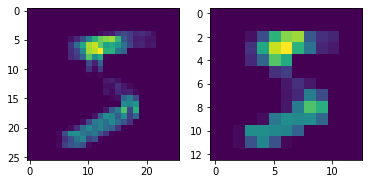

In [8]:
out1 = conv_simple(inp, weight)
plt.subplot(1,2,1); plt.imshow(out1)
out2 = pool_simple(out1)
plt.subplot(1,2,2); plt.imshow(out2)
plt.show()

# Conv層 + Pool層

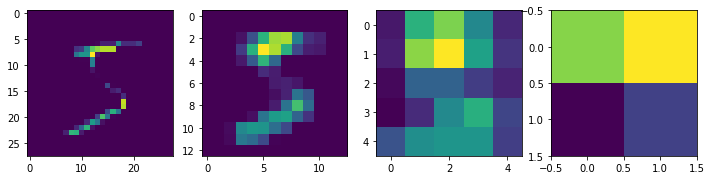

In [9]:
weight_list = [np.random.rand(3,3), np.random.rand(3,3), np.random.rand(2,2)]

out1 = conv_simple(inp, weight_list[0])
out2 = pool_simple(out1)
out3 = conv_simple(out2, weight_list[1])
out4 = pool_simple(out3)
out5 = conv_simple(out4, weight_list[2])
out6 = pool_simple(out5)

plt.figure(figsize=(12,12))
plt.subplot(1,4,1); plt.imshow(inp)
plt.subplot(1,4,2); plt.imshow(out2)
plt.subplot(1,4,3); plt.imshow(out4)
plt.subplot(1,4,4); plt.imshow(out6)
plt.show()

- ここまでで、Conv層とPool層を使うことで何かしらの特徴を抽出しながら入力データの圧縮がされていることがわかると思います。

# 【余力がある人向け】

- conv層は普通はもう少し複雑なことをします。
  - 普通は1層のconvで多数の特徴マップを出力します。具体的にはconv層は$C_{in}$枚の特徴マップから$C_{out}$枚の特徴マップを出力します。(このときkernelの数は$C_{in}*C_{out}$で、weightのサイズは$C_{in}*C_{out}$\*kernel_size[0]\*kernel_size[1])
  - やることはkernelの数だけ計算が増えるだけで、ほとんど変わらないです。
   - 特徴マップ$M_j(j=1 \sim C_{out})$を作るとき: すべての入力特徴マップ$N_i(i=1 \sim C_{in})$に対してkernel[$i$,$j$]を使ってconvを行い、できた$C_{in}$枚の特徴マップの画素ごとの和をとって$M_j$とします
- Convの実装: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

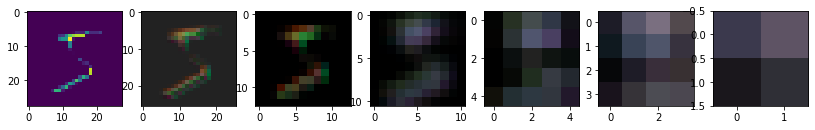

In [10]:
def conv(inp, weight):
  outs = []

  # 出力チャンネルの数だけループ
  for j in range(weight.shape[3]):  # M_j (1~C_out)
    out_j = []

    # 入力チャンネルの数だけループ
    for i in range(weight.shape[2]):  # M_i (1~C_in)

      out_ij = conv_simple(inp[i], weight[:,:,i,j])
      out_j.append(out_ij)

    out_j = np.array(out_j)
    out_j = np.sum(out_j, axis=0)  # 和
    outs.append(out_j)  # 出力チャンネル1つ完成
  
  return np.array(outs)


def pool(inp, pool_size=[2,2]):
  outs = []

  # 入力チャンネルの数(==出力チャンネルの数)だけループ
  for i in range(len(inp)):
    out_i = pool_simple(inp[i], pool_size=pool_size)
    outs.append(out_i)
  
  return np.array(outs)


C_out = 5  # 普通は256とか1024とか
# 重みの範囲を-1.~1.にします
weight_list = [
    np.random.rand(3,3,1,C_out)*2.-0.5,
    np.random.rand(3,3,C_out,C_out)*2.-0.5,
    np.random.rand(2,2,C_out,C_out)*2.-0.5,
]

# 特徴マップ数が増やせるように、次元を1つ増やす
inpc = inp.reshape(1,28,28)
out1 = conv(inpc, weight_list[0])
out2 = pool(out1)
out3 = conv(out2, weight_list[1])
out4 = pool(out3)
out5 = conv(out4, weight_list[2])
out6 = pool(out5)

N = 7  # num_layers

# 出力される特徴マップの3枚目までならRGB画像として簡単に見てみることができます
# (特徴マップを0.~1.に抑え込んでいます)
plt.figure(figsize=(N*2,2))
plt.subplot(1,N,1); plt.imshow(inpc.transpose(1,2,0))
plt.subplot(1,N,2); plt.imshow((out1[:3].transpose(1,2,0).astype(np.float)-np.min(out1))/(np.abs(out1).max()*2))
plt.subplot(1,N,3); plt.imshow((out2[:3].transpose(1,2,0).astype(np.float)-np.min(out2))/(np.abs(out2).max()*2))
plt.subplot(1,N,4); plt.imshow((out3[:3].transpose(1,2,0).astype(np.float)-np.min(out3))/(np.abs(out3).max()*2))
plt.subplot(1,N,5); plt.imshow((out4[:3].transpose(1,2,0).astype(np.float)-np.min(out4))/(np.abs(out4).max()*2))
plt.subplot(1,N,6); plt.imshow((out5[:3].transpose(1,2,0).astype(np.float)-np.min(out5))/(np.abs(out5).max()*2))
plt.subplot(1,N,7); plt.imshow((out6[:3].transpose(1,2,0).astype(np.float)-np.min(out6))/(np.abs(out6).max()*2))
plt.show()

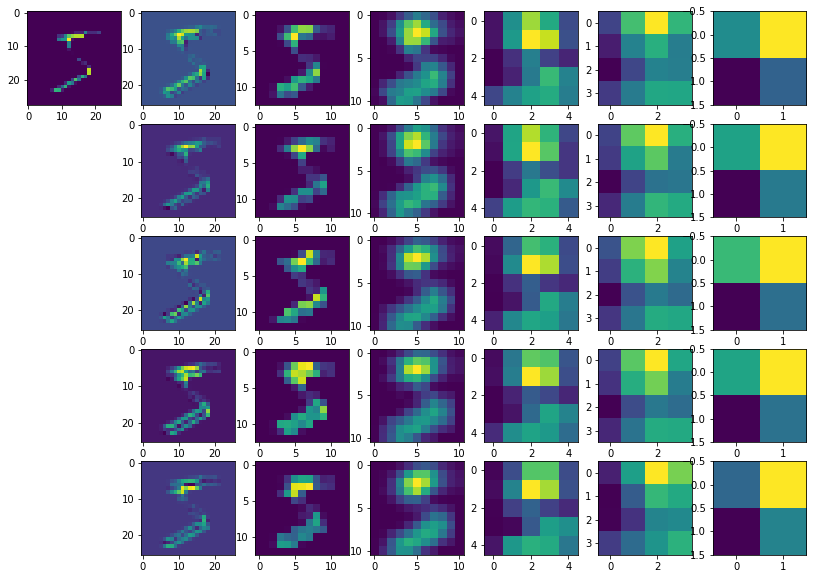

In [11]:
# 出力された特徴マップをすべて見てみます
plt.figure(figsize=(N*2,C_out*2))
plt.subplot(C_out,N,1); plt.imshow(inpc.transpose(1,2,0))

for j in range(C_out):
    plt.subplot(C_out,N,2+N*j); plt.imshow(out1[j].astype(np.float)/np.abs(out1).max())
    plt.subplot(C_out,N,3+N*j); plt.imshow(out2[j].astype(np.float)/np.abs(out2).max())
    plt.subplot(C_out,N,4+N*j); plt.imshow(out3[j].astype(np.float)/np.abs(out3).max())
    plt.subplot(C_out,N,5+N*j); plt.imshow(out4[j].astype(np.float)/np.abs(out4).max())
    plt.subplot(C_out,N,6+N*j); plt.imshow(out5[j].astype(np.float)/np.abs(out5).max())
    plt.subplot(C_out,N,7+N*j); plt.imshow(out6[j].astype(np.float)/np.abs(out6).max())
plt.show()

# Linear層

入力ベクトルから特徴を抽出します。
- より具体的にはどれだけ重みと似ているかを計算しています。
- N次元のベクトルを入力として、M次元のベクトル(M個の重みとの内積)を出力します。

- (ただし全体が正の値だと内積も大きくなってしまう点に注意してください。普通は重みの初期値の与え方を工夫したり、特徴マップ・特徴ベクトルの値を適宜正規化したりします。)

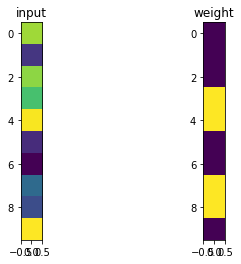

output: 0.29751964401031145


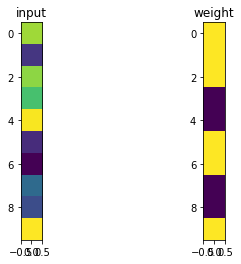

output: -0.29751964401031145


In [12]:
import numpy as np

N = 10

# 入力はベクトル
inp = np.abs(np.random.rand(N))

# Lunear層の重み
weight = np.array([0,0,0,1,1,0,0,1,1,0])
weight = ( weight - weight.mean() ) / weight.std()

# 出力は重みとの内積 (特徴量抽出)
out = np.dot(inp, weight)

plt.subplot(1,2,1); plt.title("input"); plt.imshow(inp.reshape(N,1)); 
plt.subplot(1,2,2); plt.title("weight"); plt.imshow(weight.reshape(N,1)); 
plt.show()
print("output:", out)

# --------------------------------
# 反転させた重みも用意してみます
weight = np.array([0,0,0,1,1,0,0,1,1,0])
weight = 1-weight
weight = ( weight - weight.mean() ) / weight.std()

# 出力は重みとの内積 (特徴量抽出)
out = np.dot(inp, weight)

plt.subplot(1,2,1); plt.title("input"); plt.imshow(inp.reshape(N,1)); 
plt.subplot(1,2,2); plt.title("weight"); plt.imshow(weight.reshape(N,1)); 
plt.show()
print("output:", out)

- 入力が重みと似ていると出力される値が大きくなることが分かると思います。
- 上の例は、出力が1つですが、M個の出力ができる(M個の重みをもつ)ようにしてlinear関数を定義します

In [13]:
def linear(inp, weight):
  outs = []

  # 出力チャンネルの数だけループ
  for j in range(weight.shape[1]):
    out = np.dot(inp, weight[:,j])
    outs.append(out)

  return np.array(outs)  # 特徴ベクトル

# 4次元のベクトルを入力として、3次元のベクトルを出力
weight = np.random.rand(4,3)  # M=3
inp = np.random.rand(4)

out1 = linear(inp, weight)
print(out1)

[0.72310304 0.67839193 1.29797958]


- Linearの実装: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
  - (convもですが、普通は行列を使って実装します)

In [14]:
inp = x_train[0]

weight_list = [np.random.rand(3,3)*2-0.5, np.random.rand(3,3)*2-0.5, np.random.rand(2,2)*2-0.5, np.random.rand(4,1)*2-0.5]

out1 = conv_simple(inp, weight_list[0])
out2 = pool_simple(out1)
out3 = conv_simple(out2, weight_list[1])
out4 = pool_simple(out3)
out5 = conv_simple(out4, weight_list[2])
out6 = pool_simple(out5)
out7 = out6.flatten()  # 特徴マップを特徴ベクトルに変換
out8 = linear(out7, weight_list[3])

print(out8)

[8488.68506011]


- ここまでで、Conv層、Pool層、Linear層を使い、画像から一つの値を出力するモデルが完成しました。
- しかし層を重ねるうちに様々な範囲の値をとってしまっているせいで、出力の値が暴れてしまっているので、次でこの問題を修正します。

# 活性化関数
出力の値をある範囲に抑え込みます。ここでは例としてsigmoid関数を採用します。

In [15]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [16]:
inp = x_train[0]

weight_list = [np.random.rand(3,3)*2-0.5, np.random.rand(3,3)*2-0.5, np.random.rand(2,2)*2-0.5, np.random.rand(4,1)*2-0.5]

out1 = sigmoid(conv_simple(inp, weight_list[0]))
out2 = pool_simple(out1)
out3 = sigmoid(conv_simple(out2, weight_list[1]))
out4 = pool_simple(out3)
out5 = sigmoid(conv_simple(out4, weight_list[2]))
out6 = pool_simple(out5)
out7 = out6.flatten()  # 特徴マップを特徴ベクトルに変換
out8 = sigmoid(linear(out7, weight_list[3]))

print(out8)

[0.61727717]


- これで出力の範囲が0~1に抑えられました。あとはうまくパラメータを調整するだけです。

# モデル化

最後に深層学習モデルらしい書き方にまとめます。

In [17]:
class CNN(object):
  def __init__(self):
    weight_list = [np.random.rand(3,3), np.random.rand(3,3), np.random.rand(2,2), np.random.rand(4,1)]
    self.weight_list = weight_list

  def forward(self, inp):
    out1 = sigmoid(conv_simple(inp, self.weight_list[0]))
    out2 = pool_simple(out1)
    out3 = sigmoid(conv_simple(out2, self.weight_list[1]))
    out4 = pool_simple(out3)
    out5 = sigmoid(conv_simple(out4, self.weight_list[2]))
    out6 = pool_simple(out5)
    out7 = out6.flatten()  # 特徴マップを特徴ベクトルに変換
    out8 = sigmoid(linear(out7, self.weight_list[3]))
    return out8

model = CNN()

In [18]:
inp = x_train[0]
model.forward(inp)

array([0.90129619])

以上で、入力から1つの値を出力するNNモデルができました。  
今のままではまだ各パラメータが適当なので、これからこれを調整して意味のあるモデルにしていきます。

# Loss

今、入力画像は5であるを真(0), それ以外であるを偽(1)とします。
Lossは例えばこのように求められます。

$$
  Loss = (Pred - True)^2
$$

(多クラス分類では、最後のLinear層でクラスの数だけ値を出力するように変更します)

多数学習データで入力で予測をし、Lossを求め、Lossの最小化するように重みを少しずつ更新するのが深層学習の流れです。

次の章で重みを更新する方法を学びます。

(とはいえlossの最小化はライブラリが自動でやってくれるので、基本的にここまでを理解すれば深層学習が使えて、簡単な論文であれば読めるようになると思います。)